In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay as cmd
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, chi2_contingency

In [18]:
dir = "cumulative_2025.10.04_11.45.04.csv"
df = pd.read_csv(dir)
y = df["koi_disposition"]
df = df.drop(["koi_disposition", "koi_score"], axis=1)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 81 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rowid              9564 non-null   int64  
 1   kepid              9564 non-null   int64  
 2   kepoi_name         9564 non-null   object 
 3   kepler_name        2747 non-null   object 
 4   koi_vet_stat       9564 non-null   object 
 5   koi_vet_date       9564 non-null   object 
 6   koi_pdisposition   9564 non-null   object 
 7   koi_fpflag_nt      9564 non-null   int64  
 8   koi_fpflag_ss      9564 non-null   int64  
 9   koi_fpflag_co      9564 non-null   int64  
 10  koi_fpflag_ec      9564 non-null   int64  
 11  koi_disp_prov      9564 non-null   object 
 12  koi_comment        8355 non-null   object 
 13  koi_period         9564 non-null   float64
 14  koi_time0bk        9564 non-null   float64
 15  koi_time0          9564 non-null   float64
 16  koi_eccen          9201 

In [20]:
if isinstance(y, pd.Series):
    count = y.value_counts()
    proporciones = count / count.sum() * 100

    print("Distribución de la variable 'koi_disposition':\n")
    print(count, "\n")
    print("Porcentajes de la variable:\n")
    print(proporciones, "\n")
else:
    print("Error: la variable 'y' no es una Serie de pandas.\n")

Distribución de la variable 'koi_disposition':

koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64 

Porcentajes de la variable:

koi_disposition
FALSE POSITIVE    50.595985
CONFIRMED         28.711836
CANDIDATE         20.692179
Name: count, dtype: float64 



In [21]:
df.describe(include='all')
df.isnull().sum().sort_values(ascending=False).head(20)

missing_pct = df.isnull().mean() * 100
missing_pct.sort_values(ascending=False).head(10)

# Eliminar columnas con más del 70% de NaN
threshold = 70
cols_to_drop = missing_pct[missing_pct > threshold].index
print(f"Columnas eliminadas (>{threshold}% NaN): {list(cols_to_drop)}")
df = df.drop(columns=cols_to_drop)

# Imputar columnas con ≤70% NaN usando la media (solo columnas numéricas)
cols_to_impute = missing_pct[(missing_pct <= threshold) & (missing_pct > 0)].index
numeric_cols_to_impute = df[cols_to_impute].select_dtypes(include=[np.number]).columns

for col in numeric_cols_to_impute:
    mean_value = df[col].mean()
    df[col].fillna(mean_value, inplace=True)
    print(f"Columna '{col}' imputada con valor promedio: {mean_value:.4f}")

# Confirmar que no quedan NaN en las columnas imputadas
print("\n✅ Conteo de NaN después de la imputación:")
print(df[numeric_cols_to_impute].isnull().sum())

Columnas eliminadas (>70% NaN): ['kepler_name', 'koi_longp', 'koi_ingress', 'koi_model_dof', 'koi_model_chisq', 'koi_sage']
Columna 'koi_eccen' imputada con valor promedio: 0.0000
Columna 'koi_impact' imputada con valor promedio: 0.7351
Columna 'koi_depth' imputada con valor promedio: 23792.4535
Columna 'koi_ror' imputada con valor promedio: 0.2836
Columna 'koi_srho' imputada con valor promedio: 9.1644
Columna 'koi_prad' imputada con valor promedio: 102.8918
Columna 'koi_sma' imputada con valor promedio: 0.2240
Columna 'koi_incl' imputada con valor promedio: 82.4691
Columna 'koi_teq' imputada con valor promedio: 1085.3858
Columna 'koi_insol' imputada con valor promedio: 7745.7370
Columna 'koi_dor' imputada con valor promedio: 76.7363
Columna 'koi_ldm_coeff4' imputada con valor promedio: 0.0000
Columna 'koi_ldm_coeff3' imputada con valor promedio: 0.0000
Columna 'koi_ldm_coeff2' imputada con valor promedio: 0.2544
Columna 'koi_ldm_coeff1' imputada con valor promedio: 0.4076
Columna 'koi

/tmp/ipython-input-2548955051.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mean_value, inplace=True)


In [22]:
cols_to_drop = [
    # Identificadores
    "rowid",
    "kepoi_name",

    # Variables categóricas sin relación directa con el fenómeno físico
    "koi_vet_stat",
    "koi_vet_date",
    "koi_pdisposition",
    "koi_disp_prov",
    "koi_fittype",
    "koi_limbdark_mod",
    "koi_parm_prov",
    "koi_tce_delivname",
    "koi_trans_mod",
    "koi_sparprov",

    # Enlaces o datos externos
    "koi_datalink_dvr",
    "koi_datalink_dvs",

    # Comentarios o texto libre
    "koi_comment",
]

cols_to_drop = [col for col in cols_to_drop if col in df.columns]

df = df.drop(columns=cols_to_drop)

print(f"Columnas eliminadas: {cols_to_drop}")

Columnas eliminadas: ['rowid', 'kepoi_name', 'koi_vet_stat', 'koi_vet_date', 'koi_pdisposition', 'koi_disp_prov', 'koi_fittype', 'koi_limbdark_mod', 'koi_parm_prov', 'koi_tce_delivname', 'koi_trans_mod', 'koi_sparprov', 'koi_datalink_dvr', 'koi_datalink_dvs', 'koi_comment']


In [23]:
# ==============================================================
# 🔍 Identificación y eliminación de duplicados por 'kepid'
# ==============================================================

# Recorrer los grupos por 'kepid' (solo para análisis o verificación si se desea)
for kepid_val, group in df.groupby("kepid"):
    values = group.values
    for i, row in enumerate(values):
        repeated_cols_count = 0
        for col_idx in range(values.shape[1]):
            if np.any(values[:, col_idx] == row[col_idx]) and group.shape[0] > 1:
                repeated_cols_count += 1
    # (no es necesario usar 'repeated_cols_count' para eliminar, pero se deja por similitud estructural)

# Identificar duplicados (mantener solo el primero)
duplicates_idx = df.duplicated(subset="kepid", keep="first")

# Eliminar los duplicados en df
df = df[~duplicates_idx].reset_index(drop=True)

# Eliminar las mismas filas en y
y = y[~duplicates_idx].reset_index(drop=True)

print(f"\nDespués de eliminar duplicados, el DataFrame tiene {df.shape[0]} filas únicas por kepid.")
print(f"Variable objetivo 'y' ahora tiene {y.shape[0]} elementos.")



Después de eliminar duplicados, el DataFrame tiene 8214 filas únicas por kepid.
Variable objetivo 'y' ahora tiene 8214 elementos.


In [24]:
def dynamic_iqr_factor(s, min_factor=1.5, max_factor=3.5):
    s = s.dropna()
    if s.empty:
        return 1.5
    med = np.median(s)
    iqr = s.quantile(0.75) - s.quantile(0.25)
    # dispersión relativa
    rel_disp = iqr / abs(med) if med != 0 else iqr
    # ajustar factor linealmente entre min_factor y max_factor
    factor = min_factor + (max_factor - min_factor) * rel_disp
    # limitar factor para que no sea excesivo
    return np.clip(factor, min_factor, max_factor)

# Iterar sobre columnas float64
for col in df.select_dtypes(include=["float64"]).columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1

    factor = dynamic_iqr_factor(df[col])  # calcular factor dinámico
    li = q1 - factor * iqr
    ls = q3 + factor * iqr

    out = np.where((df[col] < li) | (df[col] > ls))[0]

    print(f"{col}: {len(out)} outliers detectados con factor IQR = {factor:.2f}")

    if len(out) > 0:
        mean_val = df[col].mean()  # calcular media de la columna
        df.loc[out, col] = mean_val  # reemplazar outliers por la media
print("Outliers reemplazados totalmente")

koi_period: 1069 outliers detectados con factor IQR = 3.50
koi_time0bk: 771 outliers detectados con factor IQR = 2.06
koi_time0: 927 outliers detectados con factor IQR = 1.50
koi_eccen: 0 outliers detectados con factor IQR = 1.50
koi_impact: 57 outliers detectados con factor IQR = 3.50
koi_duration: 253 outliers detectados con factor IQR = 3.50
koi_depth: 1565 outliers detectados con factor IQR = 3.50
koi_ror: 108 outliers detectados con factor IQR = 3.50
koi_srho: 646 outliers detectados con factor IQR = 3.50
koi_prad: 300 outliers detectados con factor IQR = 3.50
koi_sma: 670 outliers detectados con factor IQR = 3.50
koi_incl: 986 outliers detectados con factor IQR = 1.66
koi_teq: 74 outliers detectados con factor IQR = 3.35
koi_insol: 931 outliers detectados con factor IQR = 3.50
koi_dor: 642 outliers detectados con factor IQR = 3.50
koi_ldm_coeff4: 0 outliers detectados con factor IQR = 1.50
koi_ldm_coeff3: 0 outliers detectados con factor IQR = 1.50
koi_ldm_coeff2: 248 outliers de

In [25]:
# ==============================================================
# Función para balancear eliminando FALSE POSITIVE
# ==============================================================
def balancear_eliminando_false_positive(df, y):
    """Elimina filas de la clase 'FALSE POSITIVE' con mayor varianza hasta balancear con minoritarias"""
    numeric_df = df.select_dtypes(include=[np.number])
    df["row_variance"] = numeric_df.var(axis=1)
    df["class"] = y.values

    class_counts = y.value_counts()
    if "FALSE POSITIVE" not in class_counts:
        print("⚠️ No se encontró la clase 'FALSE POSITIVE'. No se aplicará balanceo.")
        df.drop(columns=["row_variance", "class"], inplace=True)
        return df, y

    minority_mean = class_counts.drop("FALSE POSITIVE").mean()
    target_size = int(minority_mean)

    # Filtrar y ordenar FALSE POSITIVE por varianza
    false_pos_df = df[df["class"] == "FALSE POSITIVE"].copy()
    false_pos_df = false_pos_df.sort_values(by="row_variance", ascending=False)

    to_remove = max(len(false_pos_df) - target_size, 0)
    print(f"\n🗑️ Eliminando {to_remove} instancias de 'FALSE POSITIVE' con mayor varianza")

    false_pos_df_balanced = false_pos_df.iloc[to_remove:]
    other_classes_df = df[df["class"] != "FALSE POSITIVE"]

    # Combinar y limpiar
    df_balanced = pd.concat([false_pos_df_balanced, other_classes_df], axis=0)
    df_balanced = df_balanced.drop(columns=["row_variance"])
    y_balanced = df_balanced.pop("class")

    df_balanced = df_balanced.reset_index(drop=True)
    y_balanced = y_balanced.reset_index(drop=True)

    print("\n📊 Distribución después del balanceo:")
    print(y_balanced.value_counts(normalize=True) * 100)

    return df_balanced, y_balanced

# ==============================================================
# Balancear dataset
# ==============================================================
df_balanced, y_balanced = balancear_eliminando_false_positive(df.copy(), y.copy())



🗑️ Eliminando 2853 instancias de 'FALSE POSITIVE' con mayor varianza

📊 Distribución después del balanceo:
class
CONFIRMED         36.243238
FALSE POSITIVE    33.333333
CANDIDATE         30.423428
Name: proportion, dtype: float64


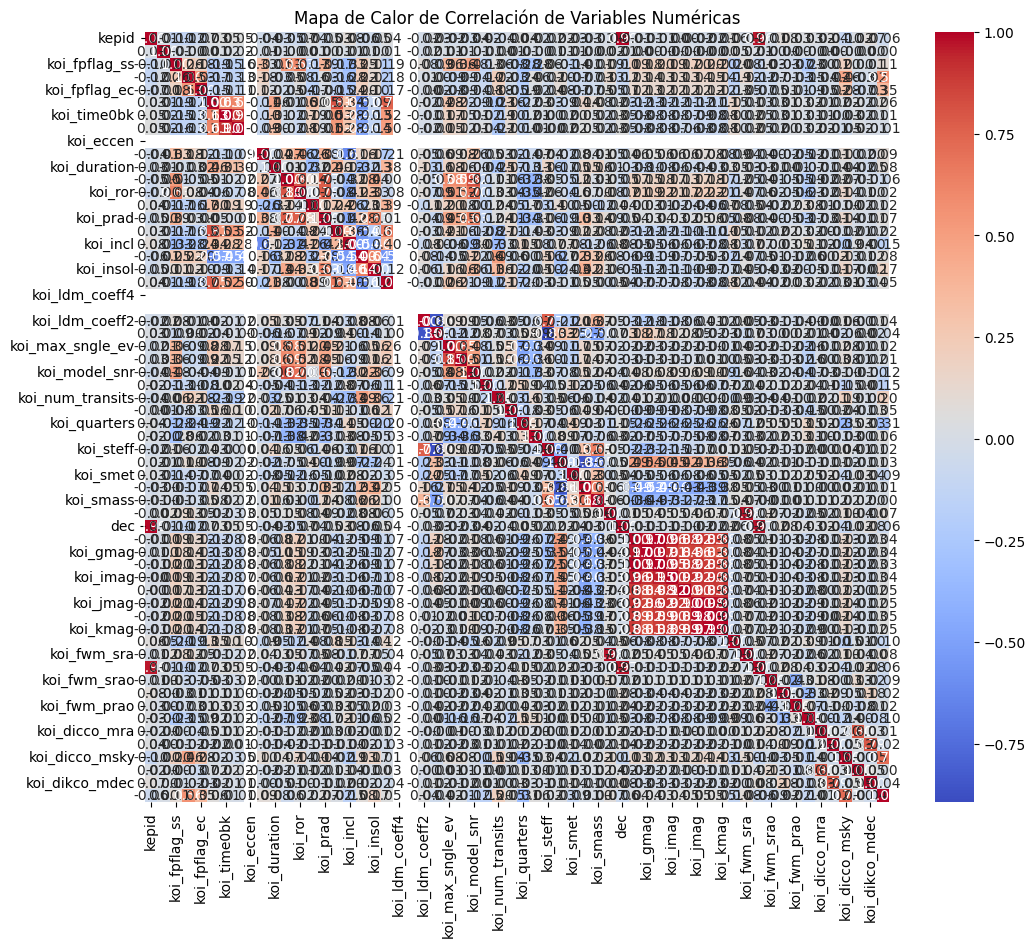


Variables con correlación > 80% que serán eliminadas: ['koi_time0', 'koi_ror', 'koi_sma', 'koi_ldm_coeff1', 'koi_max_mult_ev', 'koi_model_snr', 'koi_steff', 'koi_srad', 'dec', 'koi_gmag', 'koi_rmag', 'koi_imag', 'koi_zmag', 'koi_jmag', 'koi_hmag', 'koi_kmag', 'koi_fwm_sra', 'koi_fwm_sdec']


In [26]:
# ==============================================================
# 1️⃣ Calcular matriz de correlación (solo variables numéricas)
# ==============================================================
numeric_df = df_balanced.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# ==============================================================
# 2️⃣ Mostrar mapa de calor de correlación
# ==============================================================
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Mapa de Calor de Correlación de Variables Numéricas")
plt.show()

# ==============================================================
# 3️⃣ Identificar variables con correlación mayor al 80%
# ==============================================================
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [column for column in upper_tri.columns if any(upper_tri[column].abs() > 0.8)]

print(f"\nVariables con correlación > 80% que serán eliminadas: {high_corr}")

# ==============================================================
# 4️⃣ Eliminar variables altamente correlacionadas
# ==============================================================
df_balanced = df_balanced.drop(columns=high_corr).reset_index(drop=True)

In [27]:
# ==============================================================
# Codificar las clases
# ==============================================================
le = LabelEncoder()
y_balanced_enc = le.fit_transform(y_balanced)

print("\n🔤 Mapeo de clases:")
for k, v in dict(zip(le.classes_, le.transform(le.classes_))).items():
    print(f"  {k} → {v}")


🔤 Mapeo de clases:
  CANDIDATE → 0
  CONFIRMED → 1
  FALSE POSITIVE → 2


In [28]:
df_balanced = df_balanced.drop("kepid", axis = 1)
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5361 entries, 0 to 5360
Data columns (total 41 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   koi_fpflag_nt     5361 non-null   int64  
 1   koi_fpflag_ss     5361 non-null   int64  
 2   koi_fpflag_co     5361 non-null   int64  
 3   koi_fpflag_ec     5361 non-null   int64  
 4   koi_period        5361 non-null   float64
 5   koi_time0bk       5361 non-null   float64
 6   koi_eccen         5361 non-null   float64
 7   koi_impact        5361 non-null   float64
 8   koi_duration      5361 non-null   float64
 9   koi_depth         5361 non-null   float64
 10  koi_srho          5361 non-null   float64
 11  koi_prad          5361 non-null   float64
 12  koi_incl          5361 non-null   float64
 13  koi_teq           5361 non-null   float64
 14  koi_insol         5361 non-null   float64
 15  koi_dor           5361 non-null   float64
 16  koi_ldm_coeff4    5361 non-null   float64


In [29]:
# ==============================================================
# 3️⃣ Separar entrenamiento y prueba
# ==============================================================
X_train, X_test, y_train, y_test = train_test_split(df_balanced, y_balanced_enc, test_size=0.2, random_state=42, stratify=y_balanced_enc)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:10:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🎯 Precisión del modelo XGBoost: 0.9040

📋 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       326
           1       0.87      0.89      0.88       389
           2       0.99      0.99      0.99       358

    accuracy                           0.90      1073
   macro avg       0.90      0.90      0.90      1073
weighted avg       0.90      0.90      0.90      1073



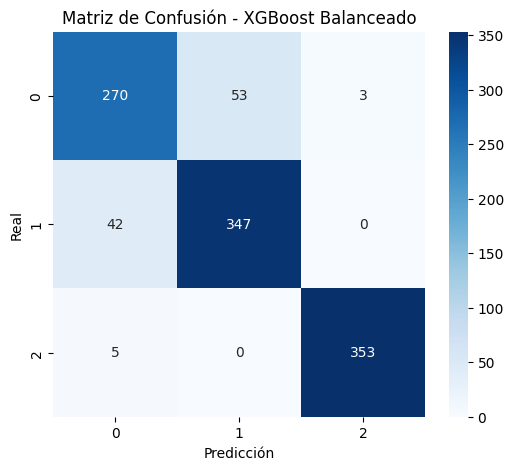

In [30]:
# ==============================================================
# 4️⃣ Entrenar XGBoost
# ==============================================================
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_train)),
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    min_child_weight=1,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss',
    use_label_encoder=False
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# ==============================================================
# 5️⃣ Evaluación
# ==============================================================
acc = accuracy_score(y_test, y_pred)
print(f"\n🎯 Precisión del modelo XGBoost: {acc:.4f}\n")
print("📋 Reporte de clasificación:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.unique(y_train),
            yticklabels=np.unique(y_train), cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - XGBoost Balanceado")
plt.show()

In [32]:
import joblib
import pandas as pd
import os

# ==============================================================
# 1️⃣ Guardar el modelo, LabelEncoder y columnas
# ==============================================================

# Ajustar LabelEncoder sobre y_train si aún no está
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Guardar el modelo entrenado
joblib.dump(xgb_model, "xgboost_model.pkl")

# Guardar el LabelEncoder
joblib.dump(le, "label_encoder.pkl")

# Guardar las columnas de entrenamiento
joblib.dump(list(X_train.columns), "train_columns.pkl")

print("✅ Archivos exportados: xgboost_model.pkl, label_encoder.pkl, train_columns.pkl")

# ==============================================================
# 2️⃣ Descargar automáticamente los archivos
# ==============================================================

try:
    # Google Colab
    from google.colab import files
    files.download("xgboost_model.pkl")
    files.download("label_encoder.pkl")
    files.download("train_columns.pkl")
except ImportError:
    # Jupyter o VSCode
    from IPython.display import FileLink, display
    display(FileLink("xgboost_model.pkl"))
    display(FileLink("label_encoder.pkl"))
    display(FileLink("train_columns.pkl"))

✅ Archivos exportados: xgboost_model.pkl, label_encoder.pkl, train_columns.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>